In [2]:
%load_ext autoreload
%autoreload 2
import os
import sr_mcmc as srmc
import argparse
import config_lib as cl
import deathTimesDataSet as dtds
import ast
import readResults as rr
import readResultsBaysian as rrb
import corner
import matplotlib.pyplot as plt
import matplotlib
import SRmodellib as sr
import SRmodellib_lifelines as srl
import emcee
import numpy as np

In [3]:
#get list of all config directories. all directories in the configs directory that start with configs
def getConfigDirs(parent_dir='configs',ignore = []):
    configDirs = []
    for dir in os.listdir(parent_dir):
        if dir.startswith('config') and dir not in ignore:
            configDirs.append(os.path.join(parent_dir,dir))
    return configDirs


def get_dataSets_and_best_sims(configDirs,resultDir,theta=False):
    dataSets = {}
    bestSims = {}
    bestSims_no_beta = {}
    time_ranges = {}
    values = {}
    current_folder = os.path.basename(os.getcwd())    
    for configDir in configDirs:
        print("At config: ", configDir)
        config = cl.read_configs(configDir)
        nsteps = int(config.get('DEFAULT', 'nsteps'))
        npeople = int(config.get('DEFAULT', 'npeople'))
        t_end = int(config.get('DEFAULT', 't_end'))
        nwalkers = int(config.get('DEFAULT', 'nwalkers'))
        nsteps = int(config.get('DEFAULT', 'nsteps'))
        time_range = ast.literal_eval(config.get('DEFAULT', 'time_range'))
        time_step_multiplier = int(config.get('DEFAULT', 'time_step_multiplier'))
        data_file = config.get('DEFAULT', 'data_file')
        results_csv_file_name = config.get('DEFAULT', 'results_csv_file_name')
        external_hazard = ast.literal_eval(config.get('DEFAULT', 'external_hazard'))
        #all paths are in absolute paths (start with ~/). change all paths to be relative to the current folder 
        # (remove everything before the current folder name)
        data_file = data_file.split(current_folder)[-1]
        #remove the first / from the paths
        data_file = data_file[1:]
        ds = dtds.dsFromFile(data_file)
        key = results_csv_file_name.split('.')[0]
        theta = rrb.getTheta(os.path.join(resultDir,results_csv_file_name))
        theta_nb = theta.copy()
        theta_nb[1] = 0
        sim = srmc.getSr(theta,nsteps=nsteps, npeople=npeople, time_step_multiplier=time_step_multiplier, t_end=t_end, external_hazard=ds.external_hazard, parallel=True)
        sim_nb = srmc.getSr(theta_nb,nsteps=nsteps, npeople=npeople, time_step_multiplier=time_step_multiplier, t_end=t_end, external_hazard=ds.external_hazard, parallel=True)
        value = rrb.getParams(os.path.join(resultDir,results_csv_file_name),[9])
        dataSets[key] = ds
        bestSims[key] = sim
        bestSims_no_beta[key] = sim_nb
        time_ranges[key] = time_range
        values[key] = value


    return dataSets, bestSims,bestSims_no_beta, time_ranges, values

In [4]:
configDirs = ['configs/configs_yeast','configs/configs_drosophila_195and217']
dataSets, bestSims,bestSimsnb, time_ranges, values = get_dataSets_and_best_sims(configDirs, 'results_csvs')

At config:  configs/configs_yeast
At config:  configs/configs_drosophila_195and217


In [5]:
print(dataSets.keys())

dict_keys(['Yeast', 'drosophila_195and217'])


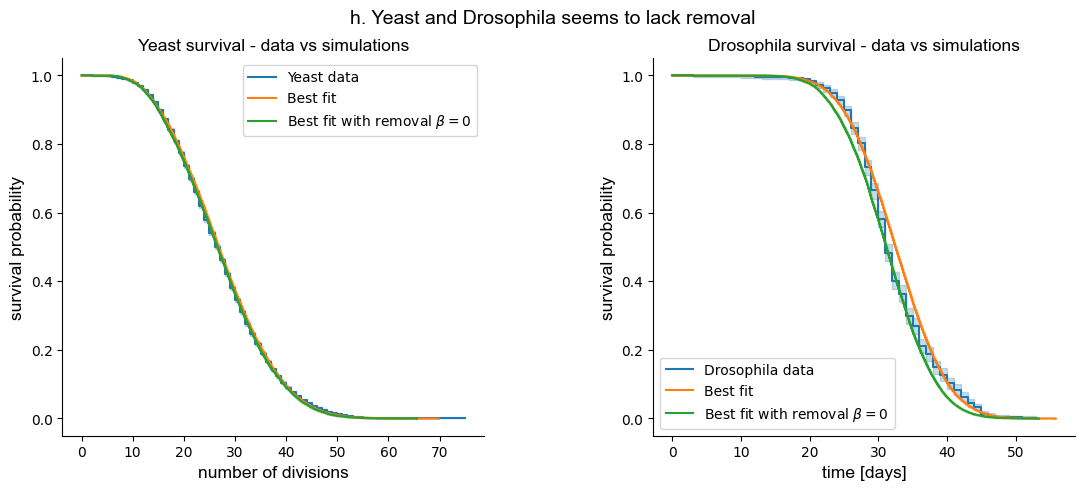

In [9]:
sf =0.7
wspacing = 3
fig_size = ((25+wspacing)*sf*2/3,7*sf) 
fig, ax = plt.subplots(1,2,figsize=fig_size)
fig.subplots_adjust(wspace=0.4) 


npad =10
title_font = {'fontname':'Arial', 'size':f'{18*sf}', 'color':'black', 'weight':'normal'}
axis_font = {'fontname':'Arial', 'size':f'{18*sf}'}
sup_title_font = {'fontname':'Arial', 'size':f'{20*sf}', 'color':'black', 'weight':'normal'}

dataSets['Yeast'].plotSurvival(ax[0],label='Yeast data')
bestSims['Yeast'].plotSurvival(ax[0],label='Best fit')
bestSimsnb['Yeast'].plotSurvival(ax[0],label='Best fit with removal $\\beta=0$')
ax[0].set_title('Yeast survival - data vs simulations', **title_font)
ax[0].set_xlabel('number of divisions', **axis_font)
ax[0].set_ylabel('survival probability', **axis_font)

dataSets['drosophila_195and217'].plotSurvival(ax[1],label='Drosophila data')
bestSims['drosophila_195and217'].plotSurvival(ax[1],label='Best fit')
bestSimsnb['drosophila_195and217'].plotSurvival(ax[1],label='Best fit with removal $\\beta=0$')
ax[1].set_title('Drosophila survival - data vs simulations', **title_font)
ax[1].set_xlabel('time [days]', **axis_font)
ax[1].set_ylabel('survival probability', **axis_font)
fig.suptitle('h. Yeast and Drosophila seems to lack removal', **sup_title_font)

fig.savefig('plots/fig3b_nobeta.pdf',format='pdf',bbox_inches='tight',transparent=True)
